## COMP2006: Graded Lab 3

In this lab, you will gain some experience in converting non-numeric features in a dataset to numeric so they can be used in a machine learning model.

**Target**: to predict `Comb Unadj FE - Conventional Fuel`

**Data set**: make sure you use the data assigned to your group!

| Groups | Data set |
| :-: | :-: |
| 1 | veh1.csv |
| 2 | veh2.csv |
| 3 | veh3.csv |
| 4 | veh4.csv |
| 5 | veh5.csv |
| 6 | veh6.csv |
| 7 | veh7.csv |
| 8 | veh8.csv |
| 10 | veh10.csv |

**Important Notes:**
- Use [Chapter 6](https://mlbook.explained.ai/catvars.html) of the textbook as a **guide**:
     - you only need to use **random forest** models;
- Use the **out-of-bag score** to evaluate models
     - Read Section 5.2 carefully so that you use this method properly
     - The oob score that you provide should be the average of 10 runs
- Code submitted for this lab should be:
     - error free
         - to make sure this is the case, before submitting, close all Jupyter notebooks, exit Anaconda, reload the lab notebook and execute all cells
     - final code
         - this means that I don't want to see every piece of code you try as you work through this lab but only the final code; only the code that fulfills the objective

> **Don't make assumptions!**


### Part 0


### Group Number 7
 - Manuel Bishop Noriega - ID 4362207
 - Robert E. Matney III - ID: 4364229

     

### Part 1 - Create and evaluate an initial model

In this part you should: 
 - read in the data
 - isolate all numeric features from original data set
 - verify there are no missing values
 - create and evaluate a baseline model 

#### Code (15 marks)

In [1]:
import pandas as pd
from rfpimp import *
# reading data
# while working on this step, to analyze and understand the data
# we used functions such as info, describe, head().T among others.
df = pd.read_csv("veh7.csv")

In [2]:
# isolating numeric data to create our baseline
df=df.select_dtypes(include=['number'])
# verifying there's no missing values
df.isnull().any()
# splitting features/target datasets
X= df.drop('Comb Unadj FE - Conventional Fuel', axis=1)
nFeatures=[col for col in X.columns.tolist()]
y= df['Comb Unadj FE - Conventional Fuel']

In [3]:
# ---------------------- FUNCTIONS ------------------------
# to prevent repeating code we'll create an evaluation function called evalute
# it will take features and target as parameters and use them to
# create and fit a random forest regressor model and calculate it's oob performance
# it returns a tuple with rf model and its oob average from 10 runs
def evaluate(X,y):
    from sklearn.ensemble import RandomForestRegressor

    oob_scores = []
    for i in range(10):
        rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
        rf.fit(X, y)
        oob_scores.append(rf.oob_score_)
    oob=sum(oob_scores) / len(oob_scores)
    print(f'Mean OOB score: {oob}')
    print(f'{rfnnodes(rf):,d} tree nodes and {np.median(rfmaxdepths(rf))} median tree height')

    return rf, oob
# showimp() show features importances, it accepts up to 4 params
# rf: a randomforest regressor
# X,y are the features and target
# features, I added this to perform different tests while converting non-numeric features
# plots the features' importances graphic
def showimp(rf,X,y,features):
    I=importances(rf,X,y, features=features)
    plot_importances(I,color='blue')

def drop_importances(X,y):
    rf=RandomForestRegressor(n_estimators=100, n_jobs=1, oob_score=True, random_state=999)
    rf.fit(X,y)
    r2=rf.oob_score_
    print(f'Baseline R^2 with no columns dropped: {r2:.5f}\n')
    for col in X.columns:
        X_col=X.copy()
        X_col=X_col.drop(col,axis=1)
        rf.fit(X_col,y)
        r2_col=rf.oob_score_
        print(f'Dropping column {col}: new R^2 is {r2_col:.5f} and difference from baseline is {r2 - r2_col}')

Mean OOB score: 0.8027964908783737
28,472 tree nodes and 14.0 median tree height


Index(['Eng Displ', '# Cyl', 'Comb Unadj FE - Conventional Fuel', '# Gears',
       'Max Ethanol % - Gasoline', 'Intake Valves Per Cyl',
       'Exhaust Valves Per Cyl'],
      dtype='object')

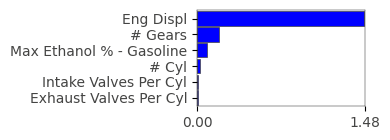

In [4]:
#call our evaluate and showimp functions for our BASELINE MODEL
baseline_model,oob1=evaluate(X,y)
showimp(baseline_model,X,y,X.columns)
df.columns

#### Question (5 marks)

Explain the purpose of creating a baseline model. 

**Enter your answer here:**
Purpose of baseline model is to have point of comparison so we can evaluate if our feature engineering improves model's predictive ability. In baseline model we use only numeric features. In this case we built it with cleaned data, that means, after trying to make sure that there are no missing values or other inconsistencies.

We tested dropping some fields like Intake and Exhaust Valves but not appreciable difference was detected.

### Part 2 - Convert non-numeric features to numeric

In this part you should: 
 - convert **all** non-numeric features to numeric
 - one of the conversions should use **one-hot encoding**
 - create **one new feature** by combining 2 or more of the existing features
 
#### Code (25 marks)

In [5]:
nanFeatures=[col for col in df.columns.tolist() if col not in nFeatures +['Comb Unadj FE - Conventional Fuel']]
df=df[nFeatures + nanFeatures]
# ------------------------------------------ converting all non-numeric features to numeric ---------------------------------------------
import category_encoders as ce
# given that most features belong to clearly defined categories (yes, no) it's possible to map them
encoder = ce.OrdinalEncoder(mapping=[{'col':'Stop/Start System (Engine Management System)  Description', 'mapping': {'No':0, 'Yes':1}},
                                     {'col':'Lockup Torque Converter', 'mapping': {'N':0, 'Y':1}},
                                     {'col':'Cyl Deact?', 'mapping': {'N':0, 'Y':1}},
                                     {'col':'Trans Creeper Gear', 'mapping': {'N':0, 'Y':1}}])
encoder.fit(df)
df=encoder.transform(df)
# one-hot encoding
encoder=ce.OneHotEncoder(cols=['Calc Approach Desc'])
encoder.fit(df)
df=encoder.transform(df)
# creating a new feature by combining 2 or more features
# caca=df.groupby('# Cyl')['Comb Unadj FE - Conventional Fuel'].mean()
# caca=df.groupby('cyl_to_consump').mean('Comb Unadj FE - Conventional Fuel')
# caca.shape

encoder=ce.TargetEncoder(cols=['# Cyl'])
encoder.fit(Xef['#Cyl'], y)
df['cyl_to_consump']=encoder.transform(Xef['#Cyl'], y)
# Xef.reset_index()
# targetfeatures=['cyls_to_consump']
# encoder=ce.TargetEncoder(cols=targetfeatures)
# encoder.fit(Xef,y)
# Xef=encoder.transform(Xef,y)
# Xef

# Xef['cyls_to_consump']=Xef['# Cyl']/y


KeyError: 'Stop/Start System (Engine Management System)  Description'

#### Explanation (25 marks)

Please provide an explanation for each conversion from non-numeric to numeric and state why this conversion is appropriate. Please also provide an explanation of the new feature created.  

### EXPLANATION

- For all non-numeric original features except "Calc Approach Desc", we decided to encode them as ordinal because we have only 2 categories for them yes/no so we map yes=1 no=0.
- with "Calc Approach Desc" we can consider it to be a Nominal feature given that there's no apparent way to order them, nevertheless because there's only 3 unique values we decided to treat them as ordinal too and used labeling encoding. At the end because it was a requirement we decided to use ONE-HOT Encoding with this one but to be honest, it seems to us that our first approach with mapping produced slightly better results. We also teste frequency encoding but we didn't find any significative difference.
- To comply with last requirement of creating a new feature by combining 2 or more existing features. we tried s

**Enter your explanation here:**

### Part 3 - Create and evaluate a final model

In this part you should:
 - create and evaluate a model using all the features from Parts 1 and 2 above 

#### Code (15 marks)

In [ ]:
ef_model,oob2=evaluate(Xef,y)
showimp(ef_model,Xef,y,Xef.columns)
drop_importances(Xef,y)

In [ ]:
X2=Xef.drop(['Calc Approach Desc_2','Cyl Deact?'],axis=1)
ef_model2,oob3=evaluate(X2,y)
showimp(ef_model2,X2,y,X2.columns)

### Part 4 - Feature importances and comparison (10 marks)

In this part you should:
 - calculate the percent difference between the results of Part 1 and Part 3 (make sure you are using the correct formula for percent difference) 
 - based on the percent difference, state whether or not the results of Part 3 are an improvement over the results of Part 1
 - use the `rfpimp_MC` package to calculate and display the feature importances for all features

#### Question (5 marks)

Based on the feature importances, are any features that you think should be removed from the data set.  Why do you think these features should be removed? 

**Enter your answer here:**